# Filtering Methods and Effects in Heart Sound Recordings
In this NoteBook we explore different filtering methods applied to Heart Sound Recordings (HSR) using Python. The HSR files used here are free available in (1). This database is characterize to be a set of single short recordings between 10 and 60 seconds.



The , perform filtering methods and analyse its effects over *the heart sound signal.*    

### Libraries needed

In [1]:

import os
import numpy as np
import wavio as wa
import sounddevice as sd
import ppfunctions_1 as ppf
import scipy.io.wavfile as wf

import matplotlib.pyplot as plt

## Signal Loading Process
We uses the **os** librarie to import the **.wav** files containing the heart sounds.

In [2]:
# Looking for heart sounds data absolute path 
l1=os.path.abspath('Data Base HS\\training\\training-a\\a0007.wav')
l1=l1.replace('\\','/')
l2=os.path.abspath('Data Base HS\\training\\training-a\\a0001.wav')
l2=l2.replace('\\','/')
# reading file
Fs1, data1 = wf.read(l1)
Fs2, data2 = wf.read(l2)
# Clear paths
del l1, l2

## Pre-Processing: Audio-Signal Basic Information (SBI)
This section is divided in two parts. The first part referred to the **Audio things** which involves **Signal Resampling** to ensure a sampling frequency of 2kHz and to convert the file into a **Mono sound**. The second part is make to get the **signal basic information (SBI)** which means the time duration of the recording and a vector time.

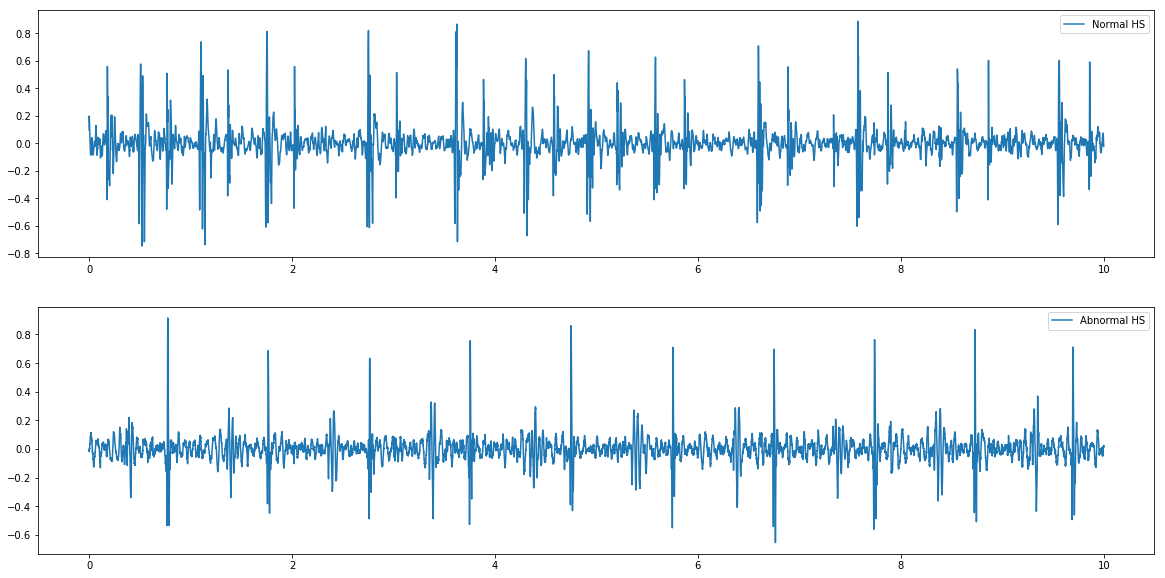

In [3]:
# Audio Pre-processing
data1, Fs1 = ppf.pre_pro_audio_PCG(data1, Fs1)
data2, Fs2 = ppf.pre_pro_audio_PCG(data2, Fs2)
# Signal basic information
dt1, vt1 = ppf.pre_pro_basicInfo_PCG(data1, Fs1)
dt2, vt2 = ppf.pre_pro_basicInfo_PCG(data2, Fs2)
# To show just ten seconds of the signal
idx1 = (np.abs(vt1-10)).argmin()
idx2 = (np.abs(vt2-10)).argmin()

plt.rcParams["figure.figsize"] = (20,10)

plt.subplot(2,1,1)
plt.plot(vt1[0:idx1], data1[0:idx1], label = "Normal HS")
plt.legend()
plt.subplot(2,1,2)
plt.plot(vt2[0:idx2], data2[0:idx2], label = "Abnormal HS")
plt.legend()
plt.show()

# Finite Impulse Response (FIR) Filter

The information containg in the cardiac acoustic is found encode in both, Frequency and Time domain. For this reason, the ideal filter would be such as it has a good Step and Frequency Response. i.e. Butterworth.

Here we will explore the most common filters and its implementation through Python

### The Recursive Moving Average Filter (RMA)

Its one of the most common FIR (Finite Impulse Response) filter, easy to understand, use and implement. Its good to reduce ramdon noise while retaining sharp step response. This means that it might performs well with signals which information are encode in the time domain. In contrast its little ability to separate one band of frequency to another makes it be some of the worst for frequency domain encoded signals.

The recursive Moving Average Filter is an algorithm to implement faster the typical moving average which function is shown bellow:
$$y[i]=\dfrac{1}{M} \sum_{j=0}^{M-1} x[i+j]$$ where M: number of points 

The algorithm of the RMA is written as:
$$y[i] = y[i-1] + x[i+p] - x[i-q]$$ where p = (M - 1)/2; M is the number of points in the moving average and q = p + 1
In the function bellow *ppf.recursive_moving_average_F* in addition to introduce the signal as an arguments, we also specify the sampling frequency of the signal and a variable *t* that specify the amount of points in *t* seconds.


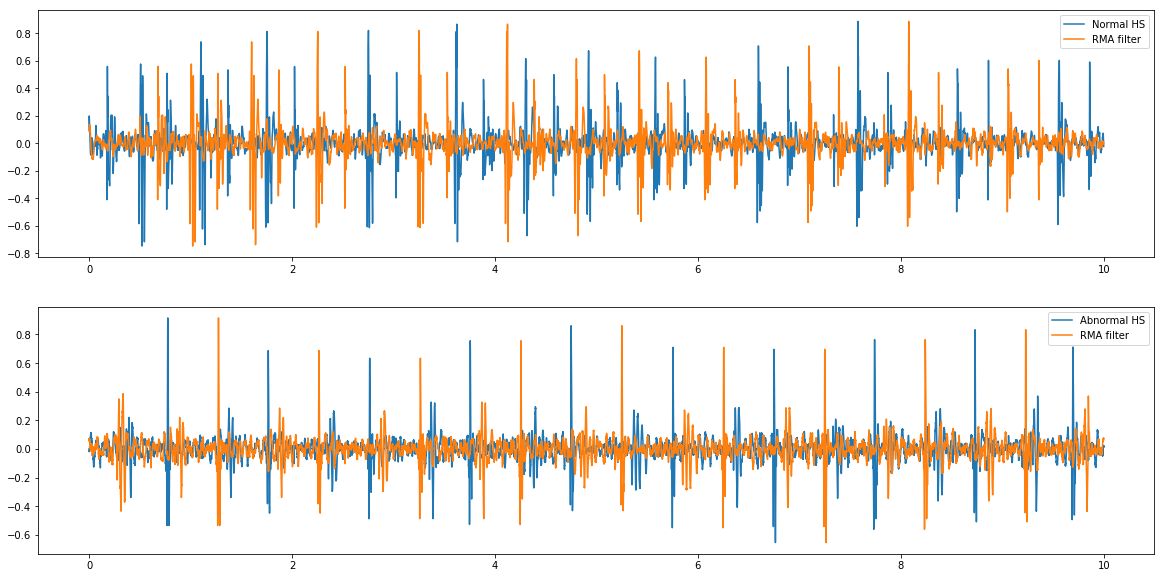

In [4]:
d_RMAF_1 = ppf.recursive_moving_average_F(data1, Fs1, 1)
d_RMAF_2 = ppf.recursive_moving_average_F(data2, Fs2, 1)

plt.subplot(2,1,1)
plt.plot(vt1[0:idx1], data1[0:idx1], label = "Normal HS")
plt.plot(vt1[0:idx1], d_RMAF_1[0:idx1], label = "RMA filter")
plt.legend()
plt.subplot(2,1,2)
plt.plot(vt2[0:idx2], data2[0:idx2], label = "Abnormal HS")
plt.plot(vt2[0:idx2], d_RMAF_2[0:idx2], label = "RMA filter")
plt.legend()
plt.show()

As showed above, the RMA filter output signal is displaced to the right several points from the original signal.

### Median Filter (python-scipy library)

Another FIR filter called **medfilt** is given by the Python library *scypy*. An example to implement this filter is given bellow:

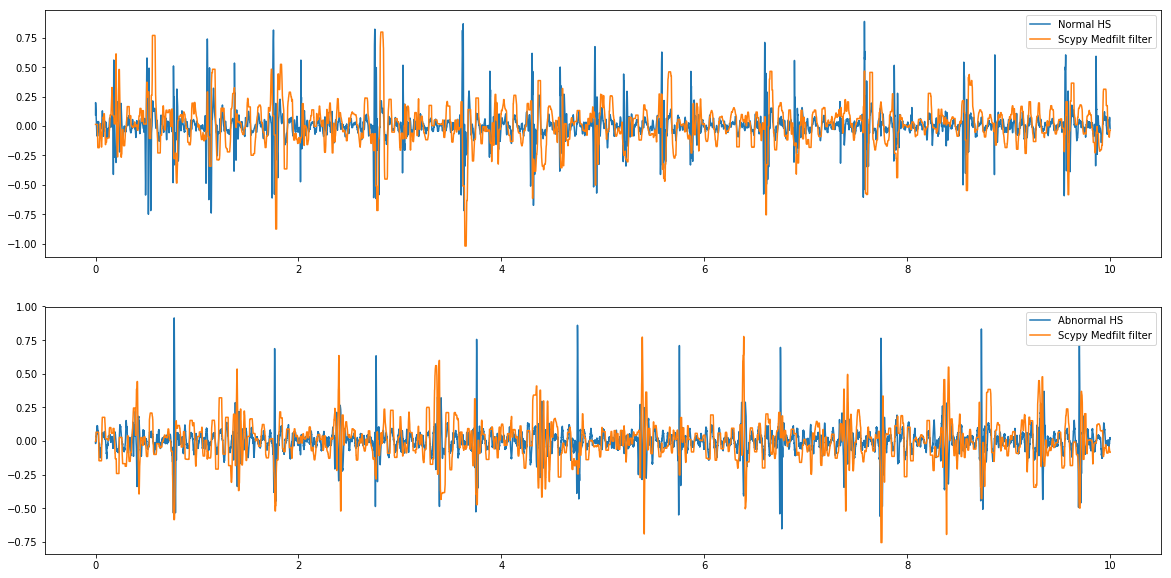

In [5]:
from scipy import signal as sg

d_RMAF_1 = ppf.vec_nor(sg.medfilt(data1, int(1+Fs1*0.05)))
d_RMAF_2 = ppf.vec_nor(sg.medfilt(data2, int(1+Fs2*0.05)))

plt.subplot(2,1,1)
plt.plot(vt1[0:idx1], data1[0:idx1], label = "Normal HS")
plt.plot(vt1[0:idx1], d_RMAF_1[0:idx1], label = "Scypy Medfilt filter")
plt.legend()
plt.subplot(2,1,2)
plt.plot(vt2[0:idx2], data2[0:idx2], label = "Abnormal HS")
plt.plot(vt2[0:idx2], d_RMAF_2[0:idx2], label = "Scypy Medfilt filter")
plt.legend()
plt.show()

### Other FIR Filters with Python 
One of the simplest way of designing better filters is by generating the coefficients and then applying the discrete convolution between this coefficients with the signal. In Python, we can use from the library scypy the function *firwin* to generate this coeffcicients and *convolve* to apply the discrete convolution. 

The PCG signal producess vibrations in the spectrum between 0-2k Hz. Here we applyed the next set of bandpass filters 1. 0.01-5Hz, 2. 5-25Hz; 3. 25-120Hz; 4. 120-240Hz; 5. 240-500Hz; 6. 500-999Hz

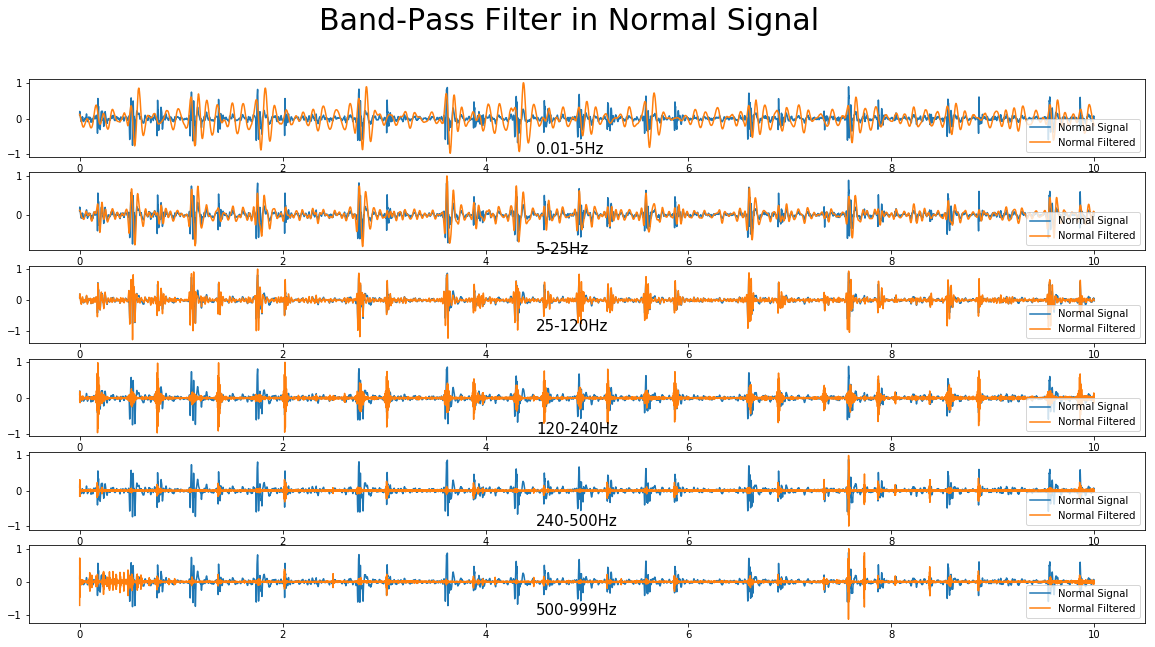

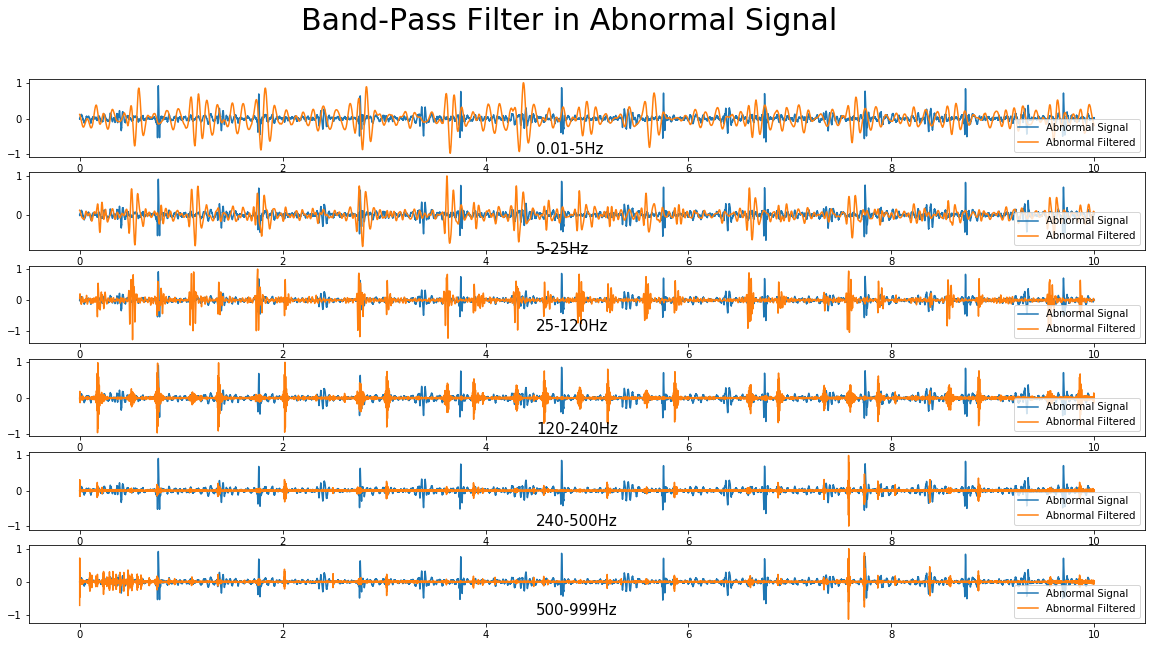

In [6]:
# Create a vector containing 6 values of Low Pass F. cutoff frequencies
lpf_cutOff = [5, 25, 120, 240, 500, 999]
# Create a vector containing 6 values of High Pass F. cutoff frequencies
hpf_cutOff = [0.01, 5, 25, 120, 240, 500]
# Defining number of samples for the band pass filter 
numtaps = int(Fs1 * 0.1)
# Initialization of vector
bandpass_coe = np.zeros((len(lpf_cutOff),numtaps))
bpf_output1 = np.zeros((len(lpf_cutOff),len(data1)))
bpf_output2 = np.zeros((len(lpf_cutOff),len(data2)))

plt.figure(1)
plt.suptitle('Band-Pass Filter in Normal Signal', fontsize=30)
plt.figure(2)
plt.suptitle('Band-Pass Filter in Abnormal Signal', fontsize=30)

for i in range(len(lpf_cutOff)):
    # Generating the band pass filter coefficients 
    bandpass_coe[i][:] = sg.firwin(numtaps, [hpf_cutOff[i], lpf_cutOff[i]], pass_zero = False, nyq = int(Fs1/2))
    # Applying the discrete convolution
    bpf_output1[i][:] = sg.convolve(data1, bandpass_coe[i][:], mode = 'same')
    bpf_output2[i][:] = sg.convolve(data2, bandpass_coe[i][:], mode = 'same')
    
    plt.figure(1)
    plt.subplot(6,1,(i+1))
    plt.text(4.5, -1, str(hpf_cutOff[i])+'-'+str(lpf_cutOff[i])+ 'Hz', fontsize = 15)
    plt.plot(vt1[0:idx1], data1[0:idx1], label = 'Normal Signal')
    plt.plot(vt1[0:idx1], ppf.vec_nor(bpf_output1[i][0:idx1]), label = 'Normal Filtered')
    plt.legend(loc = 'lower right')

    plt.figure(2)
    plt.subplot(6,1,(i+1))
    plt.text(4.5, -1, str(hpf_cutOff[i])+'-'+str(lpf_cutOff[i])+ 'Hz', fontsize = 15)
    plt.plot(vt2[0:idx2], data2[0:idx2], label = 'Abnormal Signal')
    plt.plot(vt2[0:idx2], ppf.vec_nor(bpf_output1[i][0:idx2]), label = 'Abnormal Filtered')
    plt.legend(loc = 'lower right')


As we can see above, there are good results while filtering the signals between some bandwiths but we still have the problem of displacement